In [1]:
#### Keras implementation of NN's which we will look at MNIST with

from __future__ import print_function
import keras as keras 
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.constraints import max_norm
from keras.regularizers import L2
import tensorflow as tf
#import tensorflow_datasets as tfds
import scipy
import h5py
import os
from matplotlib import pyplot as plt
import numpy as np
svhn_path="../Datasets/svhn"#"/Home/Adam/Research/Datasets/svhn"
# Hyper-parameters
K.clear_session() ## needed???
batch_size = 128
num_classes = 10
epochs = 10

img_rows, img_cols = 32, 32

### ???
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
  # I do not know why I have to do this but gpu does not work otherwise.
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


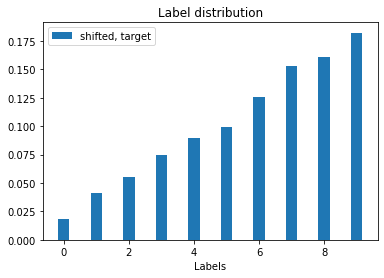

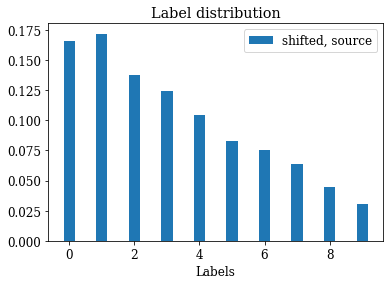

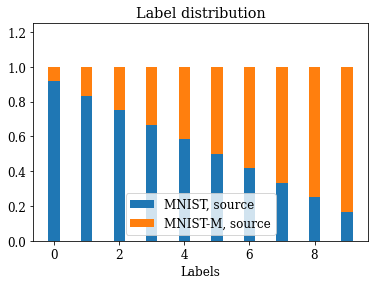

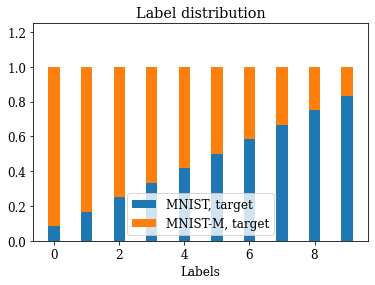

In [5]:
import random
####### label shifting and plotting

#class_label=1
#summand=1
#delta=0.7

## Note: this assumes that you have a one hot encoding and that class_label is within the range of that vector length
def label_shift(X,y,delta,class_label):
    ## takes a dataset and shifts the class label distribution by some margin delta 
    ## we will just give the ``removed'' entries back as the target distribution
    N=len(y)
    idx=[]
    y_2=[]
    X_2=[]
    x_target=[]
    y_target=[]
    for i in range(N):
        if(y[i][class_label]==1):
            idx.append(i)
    ## what proportion of the label to remove
    M=int(len(idx)*delta)
    ## choose randomly delta amount of sample to include in target
    chosen=random.sample(idx,M)
    for i in range(N):
        if(i in chosen):
            x_target.append(X[i])
            y_target.append(y[i])
        else:
            y_2.append(y[i])
            X_2.append(X[i])
    x_target=np.array(x_target)
    y_target=np.array(y_target)
    X_2=np.array(X_2)
    y_2=np.array(y_2)
    return([X_2, y_2, x_target, y_target])

## Note: this assumes that you have a one hot encoding and that class_label is within the range of that vector length
def label_shift_linear(X,y,delta,labels,decreasing=True):
    """
    X: data points
    y: labels
    delta: percentage amount which you want to decrease for each label, i.e. slope for the shifting; delta in [0,1)
    labels: a vector of the possible labels i.e. for MNIST we have labels=[0,1,2,3,4,5,6,7,8,9]
    decreasing: bool to see if you want to make the shift increasing or decreasing
    """
    ## takes a dataset and shifts the class label distribution for all labels by
    ## a linearly increasing or decreasing amount
    ## we will just remove entries of the class for now
    
    L=len(labels)
    y_2=y
    X_2=X
    x_target=[]
    y_target=[]
    ## for every label go through and remove delta*label(or delta*(L-label)) amount of them (+1 to ensure overlap)
    for label in labels:
        if decreasing:
            delta2=delta*(label+1)
        else:
            delta2=delta*(L-label+1)
        assert(delta2<1)
        X_2, y_2, x_target2, y_target2=label_shift(X_2,y_2,delta2,label)
        if (label==0):
            x_target=x_target2
            y_target=y_target2
        else:   
            x_target=np.concatenate((x_target,x_target2))
            y_target=np.concatenate((y_target,y_target2))
        #print("--------------")
        #T=np.array(x_target)
        #print(T.shape)
    return([X_2, y_2, x_target, y_target])

def plot_labeldist(labels,y_1,label_1):
    """
    labels: a vector of the possible labels i.e. for MNIST we have labels=[0,1,2,3,4,5,6,7,8,9]
    y_1: labels of dataset
    label_1: name of dataset
    """
    
    import matplotlib.pyplot as plt


    # calculate the amount of label j in both datasets
    N=len(y_1)
   # M=len(labels)
    densities_1=[]
    sum=0
    for j in labels:
        sum=0
        for i in range(len(y_1)):
            if y_1[i][j]==1:
                sum+=1
        densities_1.append(sum)
       
    densities_1_rel=[]
   
    ## calculate relative density
    for i in range(len(densities_1)):
        densities_1_rel.append(densities_1[i]/(N))
        
    #print(densities_1_rel)


    width = 0.35       # the width of the bars: can also be len(x) sequence

    fig, ax = plt.subplots()

    ax.bar(labels, densities_1_rel, width, label=label_1)
    #ax.set_ylim([0,1.25])
    ax.set_xlabel('Labels')
    ax.set_title('Label distribution')
    ax.legend()
    plt.rc('font', size=12, family='serif')
    plt.show()
    
def plot_splitbars(labels,y_1,y_2,label_1,label_2):
    """
    labels: a vector of the possible labels i.e. for MNIST we have labels=[0,1,2,3,4,5,6,7,8,9]
    y_1: labels of dataset1
    y_2: labels of dataset2
    label_1: name of dataset1
    label_2: name of dataset2
    """
    
    import matplotlib.pyplot as plt


    # calculate the amount of label j in both datasets
    densities_1=[]
    densities_2=[]
    sum=0
    for j in labels:
        sum=0
        for i in range(len(y_1)):
            if y_1[i][j]==1:
                sum+=1
        densities_1.append(sum)
        sum=0
        for i in range(len(y_2)):
            if y_2[i][j]==1:
                sum+=1
        densities_2.append(sum)
    densities_1_rel=[]
    densities_2_rel=[]
    ## calculate relative densities #### TODO: is this normalisation really what we want?
    for i in range(len(densities_1)):
        densities_1_rel.append(densities_1[i]/(densities_1[i]+densities_2[i]))
        densities_2_rel.append(densities_2[i]/(densities_1[i]+densities_2[i]))
    #print(densities_1_rel)
    #print(densities_2_rel)


    width = 0.35       # the width of the bars: can also be len(x) sequence

    fig, ax = plt.subplots()

    ax.bar(labels, densities_1_rel, width, label=label_1)
    ax.bar(labels, densities_2_rel, width , bottom=densities_1_rel,
           label=label_2)
    ax.set_ylim([0,1.25])
    ax.set_xlabel('Labels')
    ax.set_title('Label distribution')
    ax.legend()
    plt.rc('font', size=12, family='serif')
    plt.show()
    

    
######### Here we use the functions above ##############################################################

###### Add train and test together and shift the distributions to create source and target distributions
### MNIST all data
x_full=np.append(x_train,x_test, axis=0)
y_full=np.append(y_train,y_test, axis=0)
### MNIST-M all data
x_full_m=np.append(x_train_m,x_test_m, axis=0)
y_full_m=np.append(y_train_m,y_test_m, axis=0)
#x_shift,y_shift,x_shift_target,y_shift_target =label_shift(x_train,y_train,1/2,7)
x_shift, y_shift, x_shift_target, y_shift_target =label_shift_linear(x_full,y_full,1/12,[0,1,2,3,4,5,6,7,8,9])
x_shift_m, y_shift_m,x_shift_target_m, y_shift_target_m=label_shift_linear(x_full_m,y_full_m,1/12,[0,1,2,3,4,5,6,7,8,9],decreasing=False)
#rint("test of shift")
#print(x_shift_target.shape)
#print(x_shift.shape)
#print(y_shift_target.shape)
#print(y_shift.shape)
plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_shift_target,"shifted, target")
plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_shift,"shifted, source")
plot_splitbars([0,1,2,3,4,5,6,7,8,9],y_shift,y_shift_m,"MNIST, source","MNIST-M, source")
plot_splitbars([0,1,2,3,4,5,6,7,8,9],y_shift_target,y_shift_target_m,"MNIST, target","MNIST-M, target")




### TODO: make source and target be the same amount and the proportions more symmetrical across labels if possible 




In [18]:
##### Add the label shifted datasets to each other creating the source and target domain for task 2
x_source=np.append(x_shift,x_shift_m, axis=0)
y_source=np.append(y_shift,y_shift_m, axis=0)
x_target=np.append(x_shift_target,x_shift_target_m, axis=0)
y_target=np.append(y_shift_target,y_shift_target_m, axis=0)
#print(x_shift.shape)
#print(x_shift_target.shape)
## sanity check for label distribution, seems ok to me
#plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_full,"MNIST")
#plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_full_m,"MNIST-M")
#plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_source,"MNIST+MNIST-M, source")
#plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_target,"MNIST+MNIST-M, target")


##### make index lists for train and test splits for source

#N=70000 ideally, however, how can we ensure this when the amount differs between labels?
## maybe we do not care too much about it exactly
N=len(y_source)
M=len(x_shift)
train2=[]
train1=[]
test1=[]
test2=[]
ntr1=round(0.8*M)
ntr2=round(0.8*N)
### sample n_tr datapoints (w/o replacement) to be the training set at random
## do this 10 times and save the indices into a file along with the training ones
for i in range(10):
    T=random.sample(range(M),M)
    T2=random.sample(range(N),N)
    train1.append(T[:ntr1])
    train2.append(T2[:ntr2])
    test1.append(T[ntr1:])
    test2.append(T2[ntr2:])

task1=[train1,test1]
task2=[train2,test2]
import pickle
pkl_file=open('splits_task1.pkl','wb')
listoflist=task1
pickle.dump(listoflist,pkl_file)


if True:
    import pickle
    pkl_file=open('splits_task2.pkl','wb')
    listoflist=task2
    pickle.dump(listoflist,pkl_file)
    






In [37]:
##### load the splits from the file and make the split on the data
import sys
pkl_file=open('splits_task1.pkl','rb')
split1=pickle.load(pkl_file)
pkl_file.close()
traindata=[]
#print(split1[0][0])
for i in split1[0]:
    trainidx=i
    for j in trainidx:
        traindata.append(x_shift[j])
    print(traindata)
    sys.exit(-1)
for j in split1[1]:
    testdata=j

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=10000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



SystemExit: -1

/usr/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
### import svhn_cropped without grayscale

# Open the file as readonly
h5f = h5py.File('SVHN_cropped.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
Y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
Y_test = h5f['y_test'][:]
X_extra = h5f['X_extra'][:]
Y_extra = h5f['y_extra'][:]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_extra = X_extra.astype('float32')

#### make validation set from train and extra (and make extra part of train(?))

X_train=np.append(X_train,X_extra, axis=0)
Y_train=np.append(Y_train,Y_extra, axis=0)
## normalising
sigma=np.std(X_train)
X_train /= sigma 
X_test /= sigma


mu=np.mean(X_train)
X_train -= mu
X_test -= mu





print('mean, variance', mu, sigma)
print("---------------Load SVHN----------------")
print('Training set', X_train.shape, Y_train.shape)
#print('Extra set', X_extra.shape, Y_extra.shape)
print('Test set', X_test.shape, Y_test.shape)

mean, variance 2.1985865 50.549427
---------------Load SVHN----------------
Training set (604388, 32, 32, 3) (604388, 10)
Test set (26032, 32, 32, 3) (26032, 10)


In [3]:
'''
## import svhn_cropped which is svhn in 32x32 size
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
# Open the file as readonly
h5f = h5py.File('SVHN_gray.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
Y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
Y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
Y_val = h5f['y_val'][:]

# Close this file
h5f.close()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test = x_test.astype('float32')
## normalising
#_train[:,axis=3] /= 255.0 
#X_test /= 255.0
#X_val /= 255.0

print('Training set', X_train.shape, Y_train.shape)
print('Validation set', X_val.shape, Y_val.shape)
print('Test set', X_test.shape, Y_test.shape)
'''

"\n## import svhn_cropped which is svhn in 32x32 size\n####### do not load this at the moment!\n####### do not load this at the moment!\n####### do not load this at the moment!\n####### do not load this at the moment!\n####### do not load this at the moment!\n####### do not load this at the moment!\n####### do not load this at the moment!\n# Open the file as readonly\nh5f = h5py.File('SVHN_gray.h5', 'r')\n\n# Load the training, test and validation set\nX_train = h5f['X_train'][:]\nY_train = h5f['y_train'][:]\nX_test = h5f['X_test'][:]\nY_test = h5f['y_test'][:]\nX_val = h5f['X_val'][:]\nY_val = h5f['y_val'][:]\n\n# Close this file\nh5f.close()\n\nx_train = x_train.astype('float32')\nx_test = x_test.astype('float32')\nx_test = x_test.astype('float32')\n## normalising\n#_train[:,axis=3] /= 255.0 \n#X_test /= 255.0\n#X_val /= 255.0\n\nprint('Training set', X_train.shape, Y_train.shape)\nprint('Validation set', X_val.shape, Y_val.shape)\nprint('Test set', X_test.shape, Y_test.shape)\n"

In [3]:
## import mnist
(x_train, lbl_train), (x_test, lbl_test) = mnist.load_data()
x_train = np.pad(x_train,((0,0),(2,2),(2,2))) #padding to make images 32x32 and not 28x28
x_test = np.pad(x_test,((0,0),(2,2),(2,2))) 

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

## normalising
#x_train /= 255.0 
#x_test /= 255.0

## normalising to unit variance
sigma=np.std(x_train)
x_train /= sigma 
x_test /= sigma

## mean subtraction
mu=np.mean(x_train)
x_train -= mu
x_test -= mu
## make labels into categorical classes
y_train = keras.utils.to_categorical(lbl_train, num_classes)
y_test = keras.utils.to_categorical(lbl_test, num_classes)


x_train=np.expand_dims(x_train,3)
x_test=np.expand_dims(x_test,3)


### make mnist into 3 channels
x_train=np.concatenate((x_train,)*3, axis=-1)
x_test=np.concatenate((x_test,)*3, axis=-1)
print('mean, variance', mu, sigma)
print("---------------Load MNIST----------------")
print('Training set', x_train.shape, y_train.shape)
#print('Validation set', x_val.shape, y_val.shape)
print('Test set', x_test.shape, y_test.shape)


mean, variance 0.36348352 70.18035
---------------Load MNIST----------------
Training set (60000, 32, 32, 3) (60000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [4]:

### load MNIST-M

#h5f = h5py.File('MNIST-M.h5', 'r')

# Load the training, test and 
#x_train_m = h5f['x_train'][:]
#y_train_m = h5f['y_train'][:]
#x_test_m = h5f['x_test'][:]
#y_test_m = h5f['y_test'][:]
import pandas as pd

# Close this file
#h5f.close()

M = pd.read_pickle('mnistm_data.pkl')
x_train_m =M['train']
x_test_m =M['test']
y_train_m=y_train
y_test_m =y_test
x_train_m = np.pad(x_train_m,((0,0),(2,2),(2,2),(0,0))) #padding to make images 32x32 and not 28x28
x_test_m = np.pad(x_test_m,((0,0),(2,2),(2,2),(0,0)))

x_train_m = x_train_m.astype('float32')
x_test_m = x_test_m.astype('float32')
## normalising to unit variance
sigma=np.std(x_train_m)
x_train_m /= sigma 
x_test_m /= sigma

## mean subtraction
mu=np.mean(x_train_m)
x_train_m -= mu
x_test_m -= mu

print('mean, variance', mu, sigma)
print("---------------Load MNIST-M----------------")
print('Training set', x_train_m.shape, y_train_m.shape)
#print('Validation set', x_val.shape, y_val.shape)
print('Test set', x_test_m.shape, y_test_m.shape)

mean, variance 1.1809415 74.36859
---------------Load MNIST-M----------------
Training set (60000, 32, 32, 3) (60000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


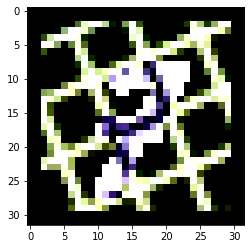

In [6]:
########## preprocessing for mnist and svhn




#print(X_test)
#print("----------------------------------------------------")
#print(x_test)


plt.imshow(x_test_m[605]) 
#print(x_test_m[303])
print(y_test_m[605])
#plt.imshow(x_test[605]) 
#print(x_test[303])
print(y_test[605])

In [7]:
## implement LeNet-5 architecture
def init_model():
    model = Sequential()
    model.add(Conv2D(6,(5,5),strides=(1,1), activation='tanh',input_shape=(32,32,1))) ## 6 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(16,(5,5),strides=(1,1), activation='tanh')) ## 16 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
    model.add(Flatten())
    #model.add(Dense(120, activation='tanh'))  #equivalent to the last conv2d above?
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(10, activation='softmax')) # output layer
    return model

In [8]:
## implement LeNet-5-like architecture
def init_SVHN_model():
    model = Sequential()
    model.add(Conv2D(64,(5,5),strides=(1,1), activation='relu',input_shape=(32,32,3),kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005))) ## 6 5x5 conv kernels
    model.add(Dropout(0.9))
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(64,(5,5),strides=(1,1), activation='relu',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005))) ## 16 5x5 conv kernels
    model.add(Dropout(0.75))
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(128,(5,5),strides=(1,1), activation='relu',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005)))
    model.add(Dropout(0.75))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(3072, activation='relu',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005)))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005)))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005))) # output layer
    
    return model

'''
We use stochastic gradient descent with
momentum: 0.9
weight_decay: 0.0005
------ this was not used on mnist<->svhn tests
and the learning rate annealing described by the following formula:
µp =µ0/(1 + α · p)^β,
where p is the training progress linearly changing from 0
to 1, µ0 = 0.01, α = 10 and β = 0.75 (the schedule
was optimized to promote convergence and low error on
the source domain).
------

Following (Srivastava et al., 2014) we also use dropout and
l_2-norm restriction when we train the SVHN architecture.
'''

'\nWe use stochastic gradient descent with\nmomentum: 0.9\nweight_decay: 0.0005\n------ this was not used on mnist<->svhn tests\nand the learning rate annealing described by the following formula:\nµp =µ0/(1 + α · p)^β,\nwhere p is the training progress linearly changing from 0\nto 1, µ0 = 0.01, α = 10 and β = 0.75 (the schedule\nwas optimized to promote convergence and low error on\nthe source domain).\n------\n\nFollowing (Srivastava et al., 2014) we also use dropout and\nl_2-norm restriction when we train the SVHN architecture.\n'

In [9]:
## implement LeNet-5-like architecture
def init_MNIST_model():
    model = Sequential()
    model.add(Conv2D(32,(5,5),strides=(1,1), activation='relu',input_shape=(32,32,3))) ## 6 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))
    model.add(Conv2D(48,(5,5),strides=(1,1), activation='relu')) ## 16 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax')) # output layer
    return model

In [10]:
## shamelessly taken from : https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras

## Custom callback to be able to evaluate and save the results from several validation sets during training
class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [2, 3]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for i, result in enumerate(results):
                
                if i == 0:
                    valuename = validation_set_name + '_loss'
                else:
                    valuename = validation_set_name + '_' + self.model.metrics[i].name
                self.history.setdefault(valuename, []).append(result)

In [11]:
def train_model(model="SVHN" ,batch_size=128 ,total_epochs=25 ,iterations=1 ,x_train=[] ,y_train=[] ,x_test=[] ,y_test=[] ,x_target=[] ,y_target=[]):
    history = AdditionalValidationSets([(x_target, y_target, 'target_val')])
    
    # Include the epoch in the file name (uses `str.format`)
    checkpoint_path = "checkpoints/"+model+"-cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights every 5 epochs
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
        ## tune when to save as needed for plots
    save_freq=50*469 ### 469 = ceiling(60000/128) i.e training set for MNIST/MNIST-M

   
    histories=[]
    M=init_SVHN_model()
    for i in range(iterations):
        if model=="SVHN":
            M=init_SVHN_model()
        elif model=="MNIST":
            M=init_MNIST_model()
        elif model=="MNIST-M":
            M=init_MNIST_model()
        elif model=="2MNIST-M":
            M=init_MNIST_model()
        # Save the weights using the `checkpoint_path` format
        M.save_weights(checkpoint_path.format(epoch=0))
        ## choose loss function, optimiser etc. and train
        M.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                      metrics=['accuracy'],)

        fit_info = M.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=total_epochs,
           verbose=1,
           validation_data=(x_test, y_test),
           callbacks=[history,cp_callback])
        histories.append(history.history)
    return histories

In [12]:
def plot_results(total_epochs,model="SVHN",result=[], xlabel="Epoch",save=True):#,ylabel="", title=""): 
    ### TODO: do one for each type of plot?
    
    from datetime import datetime

    # datetime object containing current date and time
    now = datetime.now()

    # dd/mm/YY_H:M
    dt_string = now.strftime("%d%m%Y_%H:%M")
    #print("date and time =", dt_string)
    
    ## plotting and saving to disk
    x=[i+1 for i in range(total_epochs)]

    if model=="SVHN":
        prefix=["S2MTGTACC","S2MVAL","S2MLOSS","S2MVALLOSS","S2MTGTLOSS"]
    elif model=="MNIST":
        prefix=["M2STGTACC","M2SVAL","M2SLOSS","M2SVALLOSS","M2STGTLOSS"]
    elif model=="MNIST-M":
         prefix=["MM2MTGTACC","MM2MVAL","MM2MLOSS","MM2MVALLOSS","MM2MTGTLOSS"]
    elif model=="2MNIST-M":
        prefix=["M2MMTGTACC","M2MMVAL","M2MMLOSS","M2MMVALLOSS","M2MMTGTLOSS"]

    f, ax = plt.subplots()
    ax.plot(x,result['target_val_accuracy'], '*-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Target acc'], loc = 0)
    ax.set_title('Target acc per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    if(save):
        f.savefig("./images/"+prefix[0]+dt_string+".pdf")
   

    f, ax = plt.subplots()
    ax.plot(x,result['val_accuracy'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Validation acc'], loc = 0)
    ax.set_title('Validation acc per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    if(save):
        f.savefig("./images/"+prefix[1]+dt_string+".pdf")

    f, ax = plt.subplots()
    
    ax.plot(x,result['loss'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Training loss'], loc = 0)
    ax.set_title('Training loss per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Loss')
    if(save):
        f.savefig("./images/"+prefix[2]+dt_string+".pdf")

    f, ax = plt.subplots()
    ax.plot(x,result['val_loss'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Validation loss'], loc = 0)
    ax.set_title('Validation loss per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Loss')
    if(save):
        f.savefig("./images/"+prefix[3]+dt_string+".pdf")
    
    f, ax = plt.subplots()
    ax.plot(x,result['target_val_loss'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Target acc'], loc = 0)
    ax.set_title('Target loss per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Loss')
    if(save):
        f.savefig("./images/"+prefix[4]+dt_string+".pdf")

In [13]:
def plot_results_data(sizes=[],model="SVHN",result=[],save=True):# plot for the increasing amount of data
    ### TODO: do one for each type of plot?
    
    from datetime import datetime

    # datetime object containing current date and time
    now = datetime.now()

    # dd/mm/YY_H:M
    dt_string = now.strftime("%d%m%Y_%H:%M")
    #print("date and time =", dt_string)
    
    ## plotting and saving to disk
    x=[i+1 for i in range(total_epochs)]

    if model=="SVHN":
        prefix=["S2MTGTACC","S2MVAL","S2MVALLOSS","S2MTGTLOSS"]
        target="MNIST"
    elif model=="MNIST":
        prefix=["M2STGTACC","M2SVAL","M2SVALLOSS","M2STGTLOSS"]
        target="SVHN"
    elif model=="MNIST-M":
         prefix=["MM2MTGTACC","MM2MSRCACC","MM2MSRCLOSS","MM2MTGTLOSS"]
    elif model=="2MNIST-M":
        prefix=["M2MMTGTACC","M2MMVAL","M2MMLOSS","M2MMVALLOSS","M2MMTGTLOSS"]
    
    f, ax = plt.subplots()
    ax.plot(sizes,aggregate_acc_t, '*-')
    # Plot legend and use the best location automatically: loc = 0.
    #ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
    ax.legend(['Target acc'], loc = 0)
    #ax.legend(['Validation acc'], loc = 0)
    ax.set_title('Target acc per amount of training data ('+model+'->'+target+')')
    #ax.set_title('Validation acc per epoch')
    ax.set_xlabel('Data amount')
    ax.set_ylabel('Accuracy')
    if(save):
        f.savefig("./images/data/"+prefix[0]+dt_string+".pdf")

    f, ax = plt.subplots()
    #ax.plot(x,result['accuracy'], 'o-')
    #ax.plot(x,result['val_accuracy'], 'x-')
    ax.plot(sizes,aggregate_acc_s, '*-')
    # Plot legend and use the best location automatically: loc = 0.
    #ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
    ax.legend(['Source acc'], loc = 0)
    #ax.legend(['Validation acc'], loc = 0)
    ax.set_title('Source acc per amount of training data ('+model+'->'+target+')')
    #ax.set_title('Validation acc per epoch')
    ax.set_xlabel('Data amount')
    ax.set_ylabel('Accuracy')
    if(save):
        f.savefig("./images/data/"+prefix[1]+dt_string+".pdf")

    f, ax = plt.subplots()
    #ax.plot(x,result['accuracy'], 'o-')
    #ax.plot(x,result['val_accuracy'], 'x-')
    ax.plot(sizes,aggregate_loss_s, '*-')
    # Plot legend and use the best location automatically: loc = 0.
    #ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
    ax.legend(['Source loss'], loc = 0)
    #ax.legend(['Validation acc'], loc = 0)
    ax.set_title('Source loss per amount of training data ('+model+'->'+target+')')
    #ax.set_title('Validation acc per epoch')
    ax.set_xlabel('Data amount')
    ax.set_ylabel('Loss')
    if(save):
        f.savefig("./images/data/"+prefix[2]+dt_string+".pdf")
    
    f, ax = plt.subplots()
    #ax.plot(x,result['accuracy'], 'o-')
    #ax.plot(x,result['val_accuracy'], 'x-')
    ax.plot(sizes,aggregate_loss_t, '*-')
    # Plot legend and use the best location automatically: loc = 0.
    #ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
    ax.legend(['Target loss'], loc = 0)
    #ax.legend(['Validation acc'], loc = 0)
    ax.set_title('Target loss per amount of training data ('+model+'->'+target+')')
    #ax.set_title('Validation acc per epoch')
    ax.set_xlabel('Data amount')
    ax.set_ylabel('Loss')
    if(save):
        f.savefig("./images/data/"+prefix[3]+dt_string+".pdf")

In [ ]:
'''### test for SVHN-> MNIST, 
total_epochs=220 #


iterations=10
histories=[]

#histories=train_model(model="SVHN",total_epochs=total_epochs,iterations=iterations,x_train=X_train,y_train=Y_train,x_test=X_test,y_test=Y_test,x_target=x_test,y_target=y_test)
    
histories=train_model(total_epochs=total_epochs,x_train=X_train,y_train=Y_train,x_test=X_test,y_test=Y_test,x_target=x_test,y_target=y_test)
   
                      
##### Aggregating over all the training runs                    
K=histories[0].keys()
                
result={}
for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)

    
## plotting and saving to disk
plot_results(model="SVHN",result=result,xlabel="Epoch",total_epochs=total_epochs)
'''

In [ ]:
'''### test for MNIST->SVHN
total_epochs=2000 #


iterations=10
histories=[]


    
histories=train_model(model="MNIST",total_epochs=total_epochs,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test,x_target=X_test,y_target=Y_test)
   
                      
##### Aggregating over all the training runs                    
K=histories[0].keys()
                
result={}
for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)

    
## plotting and saving to disk
plot_results(model="MNIST",result=result,xlabel="Epoch",total_epochs=total_epochs)
'''

In [ ]:
'''### test for MNIST-M-> MNIST
total_epochs=2000 #


iterations=10
histories=[]


    
histories=train_model(model="MNIST-M",total_epochs=total_epochs,x_train=x_train_m,y_train=y_train_m,x_test=x_test_m,y_test=y_test_m,x_target=x_test,y_target=y_test)
   
                      
##### Aggregating over all the training runs                    
K=histories[0].keys()
                
result={}
for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)

    
## plotting and saving to disk
plot_results(model="MNIST-M",result=result,xlabel="Epoch",total_epochs=total_epochs)
'''

In [14]:
#test for MNIST-> MNIST-M
total_epochs=200 #


iterations=1
histories=[]



histories=train_model(model="2MNIST-M",total_epochs=total_epochs,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test,x_target=x_test_m,y_target=y_test_m)


                      
##### Aggregating over all the training runs                    
K=histories[0].keys()
                
result={}
for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)

    
## plotting and saving to disk
plot_results(model="2MNIST-M",result=result,xlabel="Epoch",total_epochs=total_epochs,save=False)


Epoch 1/200
469/469 [==============================] - 3s 4ms/step - loss: 0.7533 - accuracy: 0.7628 - val_loss: 0.0855 - val_accuracy: 0.9724


KeyboardInterrupt: 

In [ ]:
'''
### test for SVHN-> MNIST,  USING only a part of the training set
total_epochs=200 #

from sklearn.model_selection import train_test_split
num_runs=1
iterations=1
histories=[]
prev_loss_t=[]
prev_loss_s=[]
prev_acc_t=[]
prev_acc_s=[]
N=len(X_train)

for runs in range(num_runs):
    target_acc=[]
    target_loss=[]
    source_acc=[]
    source_loss=[]
    sizes=[]
    
    for i in range(iterations):
        
        size=round(0.001*N)*(10*i+1)
        
        sizes.append(size)
         ## take out 1*i percent of the data and train
        X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train,Y_train,test_size=size)
        histories=train_model(total_epochs=total_epochs,x_train=X_test2,y_train=Y_test2,x_test=X_test,y_test=Y_test,x_target=x_test,y_target=y_test)
        
        # get last epochs accuracy for target
        target_acc.append(histories[0]['target_val_accuracy'][-1])
        target_loss.append(histories[0]['target_val_loss'][-1])
        source_acc.append(histories[0]['val_accuracy'][-1])
        source_loss.append(histories[0]['val_loss'][-1])
    
    ##### append the list of last epoch accuracies for each amount of data                    
    ##### to the prev_runs list
    print(target_acc)
    prev_loss_t.append(target_loss)
    prev_loss_s.append(source_loss)
    prev_acc_t.append(target_acc)
    prev_acc_s.append(source_acc)
    

### take mean over all runs

aggregate_loss_t=np.mean(prev_loss_t,axis=0)
aggregate_loss_s=np.mean(prev_loss_s,axis=0)
aggregate_acc_t=np.mean(prev_acc_t,axis=0)
aggregate_acc_s=np.mean(prev_acc_s,axis=0)

result=[]
result.append(aggregate_acc_t)
result.append(aggregate_acc_s)
result.append(aggregate_loss_s)
result.append(aggregate_loss_t)

    
## plotting and saving to disk
plot_results_data(sizes=sizes,result=result,save=False)
'''

In [ ]:
 '''
    ### test for MNIST->SVHN,  USING only a part of the training set
total_epochs=200 #

from sklearn.model_selection import train_test_split
num_runs=5
iterations=15
histories=[]
prev_loss_t=[]
prev_loss_s=[]
prev_acc_t=[]
prev_acc_s=[]
N=len(X_train)

for runs in range(num_runs):
    target_acc=[]
    target_loss=[]
    source_acc=[]
    source_loss=[]
    sizes=[]
    
    for i in range(iterations):
        
        size=round(0.001*N)*(10*i+1)
        
        sizes.append(size)
         ## take out 1*i percent of the data and train
        x_train2, x_test2, y_train2, y_test2 = train_test_split(x_train,y_train,test_size=size)
        histories=train_model(model='MNIST',total_epochs=total_epochs,x_train=x_test2,y_train=y_test2,x_test=x_test,y_test=y_test,x_target=X_test,y_target=Y_test)
        
        # get last epochs accuracy for target
        target_acc.append(histories[0]['target_val_accuracy'][-1])
        target_loss.append(histories[0]['target_val_loss'][-1])
        source_acc.append(histories[0]['val_accuracy'][-1])
        source_loss.append(histories[0]['val_loss'][-1])
    
    ##### append the list of last epoch accuracies for each amount of data                    
    ##### to the prev_runs list
    print(target_acc)
    prev_loss_t.append(target_loss)
    prev_loss_s.append(source_loss)
    prev_acc_t.append(target_acc)
    prev_acc_s.append(source_acc)
    

### take mean over all runs

aggregate_loss_t=np.mean(prev_loss_t,axis=0)
aggregate_loss_s=np.mean(prev_loss_s,axis=0)
aggregate_acc_t=np.mean(prev_acc_t,axis=0)
aggregate_acc_s=np.mean(prev_acc_s,axis=0)

result=[]
result.append(aggregate_acc_t)
result.append(aggregate_acc_s)
result.append(aggregate_loss_s)
result.append(aggregate_loss_t)

    
## plotting and saving to disk
plot_results_data(model='MNIST',sizes=sizes,result=result)
    
    
'''

In [ ]:
    '''
    ######## PLOTS for MNIST ############
f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
#ax.plot(x,result['val_accuracy'], 'x-')
ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (MNIST->SVHN)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("MNIST2SVHN.pdf")
#f.savefig("MNISTval.pdf")


f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
ax.plot(x,result['val_accuracy'], 'x-')
#ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (MNIST->SVHN)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("MNIST2SVHN.pdf")
#f.savefig("MNIST2SVHNval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_loss'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Training loss per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("MNIST2SVHNloss.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_loss'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Validation loss per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("MNIST2SVHNvalloss.pdf")


############SVHN PLOTS ############ 

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
#ax.plot(x,result2['val_accuracy'], 'x-')
ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (SVHN->MNIST)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_accuracy'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_loss'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Training loss per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTloss.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_loss'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Validation loss per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTvalloss.pdf")
'''